In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Configuración Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Function to segment data into 5-second sections
def segment_signal(data, sampling_rate=173.6, segment_length=5.0, overlap=1.4):
    samples_per_segment = int(sampling_rate * segment_length)
    overlap_samples = int(sampling_rate * overlap)

    segments = []
    for i in range(4):  # First four segments
        start_idx = i * samples_per_segment
        segments.append(data[start_idx:start_idx + samples_per_segment])

    # Fifth segment with overlap
    start_idx = 3 * samples_per_segment - overlap_samples
    segments.append(data[start_idx:start_idx + samples_per_segment])

    return segments

# Function to read, label, and segment the data
def read_label_and_segment(folder, label, sampling_rate=173.6):
    base_path = '/gdrive/MyDrive/TEG-EEG/dataset_bonn/'
    full_path = os.path.join(base_path, folder)
    files = os.listdir(full_path)
    segmented_data = []
    labels = []
    for file in files:
        filepath = os.path.join(full_path, file)
        with open(filepath, 'r') as f:
            samples = np.loadtxt(f)
            # Segment each file into 5-second sections
            segments = segment_signal(samples, sampling_rate=sampling_rate)
            segmented_data.extend(segments)
            labels.extend([label] * len(segments))
    return np.array(segmented_data), np.array(labels)

# Read, label, and segment data
data_ZO, labels_ZO = read_label_and_segment('Z', 0)
data_O, labels_O = read_label_and_segment('O', 0)
data_NF, labels_NF = read_label_and_segment('N', 1)
data_F, labels_F = read_label_and_segment('F', 1)
data_S, labels_S = read_label_and_segment('S', 2)

# Combine the datasets
all_data = np.concatenate([data_ZO, data_O, data_NF, data_F, data_S])
all_labels = np.concatenate([labels_ZO, labels_O, labels_NF, labels_F, labels_S])

print(all_data.shape)

# Normalize the data
mu, sigma = np.mean(all_data), np.std(all_data)
all_data_normalized = (all_data - mu) / sigma

# Find the minimum and maximum values in the dataset
min_value = np.min(all_data)
max_value = np.max(all_data)

# Normalize the data between -1 and 1
#all_data_normalized = 2 * (all_data - min_value) / (max_value - min_value) - 1

# Check the new min and max values to ensure normalization
print(f'Min value after normalization: {np.min(all_data_normalized)}')
print(f'Max value after normalization: {np.max(all_data_normalized)}')

print(f'mu: {np.mean(all_data_normalized)}')
print(f'sigma: {np.std(all_data_normalized)}')

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights_dict = dict(enumerate(class_weights))


Mounted at /gdrive
(2500, 868)
Min value after normalization: -11.391450116125661
Max value after normalization: 12.467208378606498
mu: -1.5717074339393922e-18
sigma: 0.9999999999999999


In [3]:

import tensorflow as tf

from keras.utils import to_categorical

def window_data(X, Y, wsize, overlap):
    X_v = []
    Y_v = []

    # Calculate stride based on overlap
    stride = wsize - overlap

    for x, y in zip(X, Y):
        # Window the signal "x" and create corresponding labels
        for start in range(0, len(x) - wsize + 1, stride):
            x_v = x[start:start + wsize]
            X_v.append(x_v)
            Y_v.append(y)  # Repeat the label for each window

    # Convert the lists X_v, Y_v to NumPy arrays
    X_v = np.array(X_v)
    Y_v = np.array(Y_v)

    # Shuffling the data
    #p = np.random.permutation(len(X_v))
    #X_v = X_v[p]
    #Y_v = Y_v[p]

    return X_v, Y_v.flatten()


def split_data(data, labels, num_classes=3):
    # Convert labels to one-hot encoding
    one_hot_labels = to_categorical(labels, num_classes=num_classes)

    # Split the dataset into training, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42, shuffle=True)
    test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42, shuffle=True)


    # Split the dataset into training, validation, and test sets
    return train_data, val_data, test_data, train_labels, val_labels, test_labels

# Example usage
window_size = 128  # Example value
overlap = 0        # Overlap can be set to zero

windowed_data, windowed_labels = window_data(all_data_normalized, all_labels, window_size, overlap)

print(windowed_data.shape)
print(windowed_labels.shape)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(windowed_data, windowed_labels, num_classes=3)  # Assuming 3 classes

print(X_train.shape)
print(X_val.shape)

(15000, 128)
(15000,)
(12000, 128)
(1500, 128)


In [4]:
# test new autoencoder

import tensorflow as tf

func1 = 'relu'
func2 = 'linear'

tf.random.set_seed(157) # Reproducibilidad del entrenamiento
# Definimos la entrada
entrada = tf.keras.layers.Input(shape=(window_size,))

def encoder_function(entrada):

  # Agregamos una capa de convolución con 32 filtros, tamaño de kernel de 3, y activación relu
  entrada_convolucional = tf.keras.layers.Reshape((window_size, 1))(entrada)
  conv1 = tf.keras.layers.Conv1D(16, 3, padding='same', activation=func1)(entrada_convolucional)

  # Agregamos una capa de pooling con tamaño de pool de 2
  maxpool1 = tf.keras.layers.MaxPooling1D(2)(conv1)
  maxpool1 = tf.keras.layers.Dropout(0.05)(maxpool1)

  encoder = tf.keras.layers.Dense(window_size, activation = func1,
                                  name='bottleneck')(maxpool1)
  encoder = tf.keras.layers.ActivityRegularization(l1=0.004)(encoder)

  # Aplicamos dropout para intentar reducir el overfitting
  encoder = tf.keras.layers.Dropout(0.05)(encoder)


  return encoder

def decorder_function(encoder_input):
  # Agregamos una capa de Reshape para aplanar la salida y pasarla a la capa conv1d_transpose_52
  transpuesta1 = tf.keras.layers.Conv1DTranspose(16, 3, padding='same', activation=func1)(encoder_input)
  transpuesta1 = tf.keras.layers.UpSampling1D(2)(transpuesta1)

  decoder_output = tf.keras.layers.Conv1DTranspose(1, 3, padding='same', activation=func2)(transpuesta1)

  # Aplicamos dropout para intentar reducir el overfitting
  decoder_output = tf.keras.layers.Dropout(0.05)(decoder_output)
  decoder_output = tf.keras.layers.Reshape((window_size,))(decoder_output)
  decoder_output = tf.keras.layers.Dense(window_size, activation=func2)(decoder_output)

  return decoder_output

# Definimos una red CNN simple
def cnn_simple(input_layer):
    x = tf.keras.layers.Reshape((window_size, 1))(input_layer)  # Redimensionamos la entrada para la CNN
    x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='linear', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='linear', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    return x


# Definimos el autoencoder como el modelo que toma la entrada y devuelve la salida del decoder
autoencoder = tf.keras.models.Model(entrada, decorder_function(encoder_function(entrada)))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile( loss='mse',
    optimizer=optimizer)

#autoencoder.build((None, input_size))

autoencoder.summary()

# Adding Gaussian noise to the training data


noise_train = np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
noise_val = np.random.normal(loc=0.0, scale=0.1, size=X_val.shape)

X_train_noisy = X_train + noise_train
X_val_noisy = X_val + noise_val

# Training the DSAE
# -------------------------------------------------
# Train the autoencoder
history = autoencoder.fit(
    x = X_train_noisy,
    y = X_train_noisy,
    batch_size=32,
    epochs = 50,
    validation_data = (X_val_noisy,X_val_noisy),
    verbose=2
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 128, 16)             │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 64, 128)             │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activity_regularization              │ (None, 64, 128)             │               0 │
│ (ActivityRegularization)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 64, 16)              │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 128, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 128, 1)              │              49 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 - 8s - 20ms/step - loss: 12.8668 - val_loss: 5.2848
Epoch 2/50
375/375 - 1s - 2ms/step - loss: 3.1868 - val_loss: 1.9182
Epoch 3/50
375/375 - 1s - 2ms/step - loss: 1.5176 - val_loss: 1.2190
Epoch 4/50
375/375 - 1s - 2ms/step - loss: 1.0823 - val_loss: 0.9804
Epoch 5/50
375/375 - 1s - 2ms/step - loss: 0.8743 - val_loss: 0.8059
Epoch 6/50
375/375 - 1s - 2ms/step - loss: 0.7288 - val_loss: 0.6731
Epoch 7/50
375/375 - 1s - 2ms/step - loss: 0.6215 - val_loss: 0.5777
Epoch 8/50
375/375 - 1s - 2ms/step - loss: 0.5424 - val_loss: 0.5010
Epoch 9/50
375/375 - 1s - 2ms/step - loss: 0.4804 - val_loss: 0.4367
Epoch 10/50
375/375 - 1s - 2ms/step - loss: 0.4286 - val_loss: 0.3854
Epoch 11/50
375/375 - 1s - 2ms/step - loss: 0.3889 - val_loss: 0.3443
Epoch 12/50
375/375 - 1s - 2ms/step - loss: 0.3527 - val_loss: 0.3095
Epoch 13/50
375/375 - 1s - 2ms/step - loss: 0.3245 - val_loss: 0.2819
Epoch 14/50
375/375 - 1s - 2ms/step - loss: 0.3017 - val_loss: 0.2601
Epoch 15/50
375/375 - 1s - 

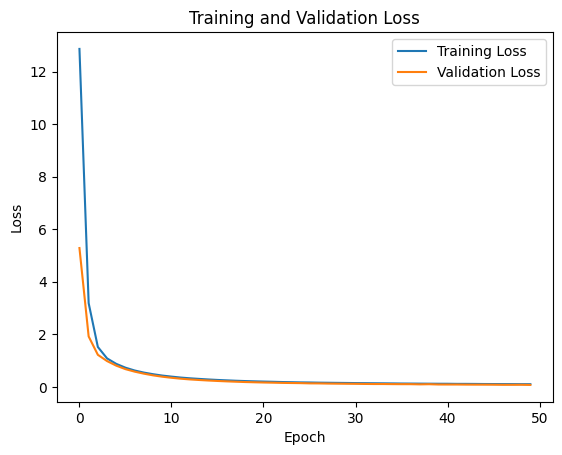

In [5]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Classifier

In [ ]:
encode = tf.keras.models.Model(inputs=autoencoder.input,
                               outputs=autoencoder.get_layer('bottleneck').output)
encode.output

<KerasTensor shape=(None, 64, 128), dtype=float32, sparse=False, name=keras_tensor_19>

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Reshape, Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense, Dropout, Input, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_classes = 3

# Definir la LSTM
def lstm_function(input_layer):
    # Reshape para que sea compatible con LSTM
    lstm_input = Reshape((window_size, 1))(input_layer)

    # Capa LSTM con 50 unidades
    lstm_output = LSTM(50, return_sequences=False)(lstm_input)
    return lstm_output

def fc(enco):
    # Capa Nro-1
   # x = Conv1D(32, kernel_size=3, activation='linear', padding='valid')(enco)

    x = enco
    # Capa Nro-7
    x = Flatten()(x)


    # Capa Nro-9
    #x = Dense(num_classes, activation='softmax')(x)
    return x

encode = tf.keras.models.Model(inputs=autoencoder.input,
                               outputs=autoencoder.get_layer('bottleneck').output)

# Pasar la misma entrada por la red CNN simple
cnn_output = cnn_simple(entrada)

lstm_output = lstm_function(entrada)


# Concatenar las salidas del encoder y de la CNN
concatenated_output = Concatenate()([fc(encode.output), cnn_output, lstm_output])

#full_model = tf.keras.models.Model(entrada, fc(encode.output))

# Capa densa con activación softmax para clasificación en 3 clases
output_layer = Dense(3, activation='softmax')(concatenated_output)

# Crear el modelo completo
full_model = Model(inputs=entrada, outputs=output_layer)
encode = tf.keras.models.Model(entrada, encode.output)

# Freeze the layers in the encoder model
for layer in encode.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

full_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_encoded = full_model.predict(X_train_noisy)
X_val_encoded = full_model.predict(X_val_noisy)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce la tasa de aprendizaje a la mitad
    patience=5,  # Espera 5 épocas antes de reducir la tasa de aprendizaje
    min_lr=1e-6  # No reduce la tasa de aprendizaje por debajo de este valor
)


# Add Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The performance metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

batch_size = 16  # O prueba con 16, 128, etc.

# Train the classifier with early stopping
classifier_history = full_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]  # Añadir ReduceLROnPlateau
)

# Evaluate the model
loss, accuracy = full_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/120
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3433 - loss: 1.0964 - val_accuracy: 0.3767 - val_loss: 1.0407 - learning_rate: 1.0000e-05
Epoch 2/120
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3596 - loss: 1.0216 - val_accuracy: 0.5880 - val_loss: 0.9691 - learning_rate: 1.0000e-05
Epoch 3/120
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5693 - loss: 0.9083 - val_accuracy: 0.6287 - val_loss: 0.8004 - learning_rate: 1.0000e-05
Epoch 4/120
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6243 - loss: 0.7769 - val_accuracy: 0.7053 - val_loss: 0.7287 - learning_rate: 1.0000e-05
Epoch 5/120
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6868 - loss: 0.7074 - val_accuracy: 0.7033 - val_loss: 0.6958 - learning_rate: 1.0000e-05
Epoch 6/120
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7031 - loss: 0.6752 - val_accuracy: 0.7080 - val_loss: 0.6747 - lea


# Balanceo de clases

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Balancear las clases utilizando SMOTE
def balance_classes(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Crear un modelo de clasificador mejorado
num_classes = 3

def create_classifier(inputs):

    x = Conv1D(128, kernel_size=3, activation='linear', padding='same')(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(100, activation='linear')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='linear')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return outputs

encode = tf.keras.models.Model(inputs=autoencoder.input,
                               outputs=autoencoder.get_layer('bottleneck').output)

classifier = tf.keras.models.Model(entrada, create_classifier(encode.output))
encode = tf.keras.models.Model(entrada, encode.output)

# Freeze the layers in the encoder model
for layer in encode.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Asume que `X_train`, `y_train`, `X_val`, `y_val`, `X_test` y `y_test` ya están definidos
# Sobremuestrear la clase INTERICTAL utilizando SMOTE
X_train_resampled, y_train_resampled = balance_classes(X_train, y_train)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the classifier with early stopping and learning rate reduction
classifier_history = classifier.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping and learning rate reduction
)

# Evaluate the model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4057 - loss: 1.0978 - val_accuracy: 0.5693 - val_loss: 1.0950
Epoch 2/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5170 - loss: 1.0921 - val_accuracy: 0.5680 - val_loss: 1.0869
Epoch 3/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5236 - loss: 1.0802 - val_accuracy: 0.5627 - val_loss: 1.0713
Epoch 4/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5264 - loss: 1.0583 - val_accuracy: 0.5680 - val_loss: 1.0446
Epoch 5/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5531 - loss: 1.0240 - val_accuracy: 0.5707 - val_loss: 1.0070
Epoch 6/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5673 - loss: 0.9799 - val_accuracy: 0.5700 - val_loss: 0.9646
Epoch 7/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5812 - loss: 0.9353 - val_accuracy: 0.5747 - val_loss: 0.9208
Epoch 8/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5857 - loss: 0.8927 - val_accuracy: 

# Grafica de perdida y precision del clasificador

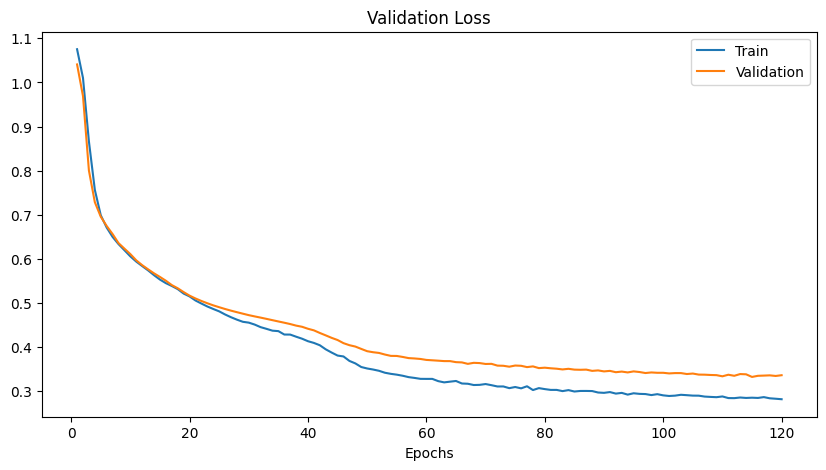

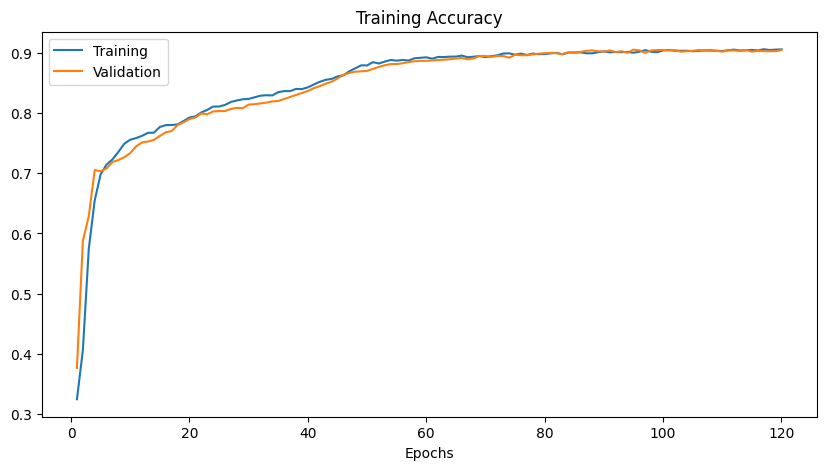

In [7]:
import matplotlib.pyplot as plt

# Plotting validation accuracy and validation loss on the same graph
plt.figure(figsize=(10, 5))
epochs = range(1, len(classifier_history.history['val_loss']) + 1)

plt.plot(epochs, classifier_history.history['loss'], label='Train')
plt.plot(epochs, classifier_history.history['val_loss'], label='Validation')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Plotting training accuracy and training loss on the same graph
plt.figure(figsize=(10, 5))

plt.plot(epochs, classifier_history.history['accuracy'], label='Training')
plt.plot(epochs, classifier_history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Metricas

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


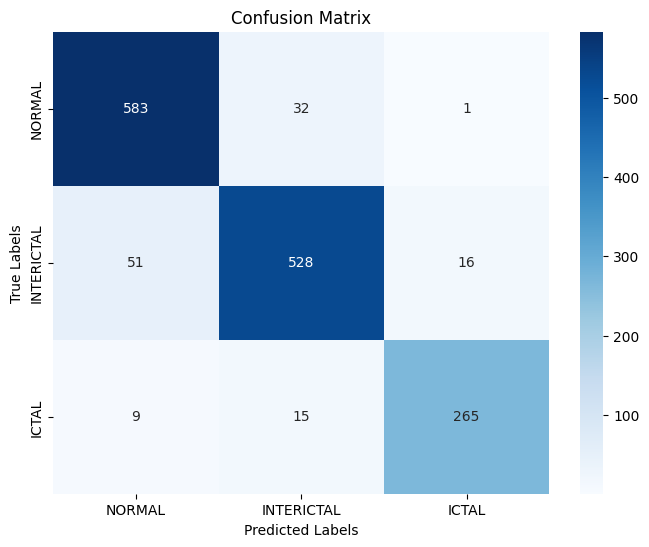

        Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.946429     0.946429     0.961494  0.926132
1  INTERICTAL   0.887395     0.887395     0.927568  0.902564
2       ICTAL   0.916955     0.916955     0.980296  0.928196


In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
n_classes = 3

label_names = ['NORMAL', 'INTERICTAL', 'ICTAL']
#encode = tf.keras.models.Model(entrada, encode)

#encoded_test = encode.predict(X_test)

# Get the predictions

y_pred_prob = full_model.predict(X_test)  # Realizar las predicciones
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Obtener la clase predicha
y_true = np.argmax(y_test, axis=1)  # Convertir las etiquetas verdaderas a clases

# Calculate sensitivity, specificity, and F1 score
# Function to calculate specificity
def calculate_specificity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i, label in enumerate(labels):
        true_negatives = np.delete(np.delete(cm, i, axis=0), i, axis=1).sum()
        false_positives = np.delete(cm[i, :], i).sum()
        specificity.append(true_negatives / (true_negatives + false_positives))
    return specificity

# Get the predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity, specificity, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(n_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(n_classes)]
specificity = calculate_specificity(y_true, y_pred, labels=[0, 1, 2])

# Calculate precision for each class
precision = []
for i, label in enumerate(label_names):
    tp = cm[i, i]  # True positives
    fp = np.delete(cm[i, :], i).sum()  # False positives
    precision.append(tp / (tp + fp))

# Plot confusion matrix for each class
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a dataframe for sensitivity, specificity, and F1 score
metrics_df = pd.DataFrame({
    'Class': label_names,
    'Precision': precision,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1_scores
})

# Display the dataframe as a table
print(metrics_df)

#Resultados

##con lr 0.0001 y el decoder con funcion de activacion linear:



```
Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.969156     0.969156     0.977778  0.946868
1  INTERICTAL   0.910924     0.910924     0.942949  0.929674
2       ICTAL   0.955017     0.955017     0.989309  0.963351
```

## **Balanceo de Clases y Aumento de Datos** con funcion de activacion linear:

```
 Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.990260     0.990260     0.992481  0.925645
1  INTERICTAL   0.818487     0.818487     0.892644  0.894399
2       ICTAL   0.975779     0.975779     0.994147  0.951096
```

## **Balanceo de Clases y Aumento de Datos** con funcion de activacion relu menos la ultima:



```
        Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.980519     0.980519     0.985330  0.930663
1  INTERICTAL   0.842017     0.842017     0.904954  0.905967
2       ICTAL   0.982699     0.982699     0.995809  0.953020
```
## con mejora para la clase 1

```
Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.961039     0.961039     0.972093  0.942675
1  INTERICTAL   0.884034     0.884034     0.926907  0.913988
2       ICTAL   0.968858     0.968858     0.992475  0.944351
```




